In [1]:
import datasets
from datasets import load_dataset
from pathlib import Path
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "./datasets/FinQuestions_v2"
token_dir = "./tokenizers/"
model_dir = "./models/"
model_name = "thenlper/gte-small-zh"  # ~61MB
output_dir="./finetune_tiny_v2"

finq = load_dataset("parquet", data_dir=data_dir)

# 下面两行代码只需首次运行
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.save_pretrained(token_dir+model_name)

tokenizer = AutoTokenizer.from_pretrained(token_dir+model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized = finq.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "FALSE", 1: "TRUE"}
label2id = {"FALSE": 0, "TRUE": 1}

# 下面两行代码只需首次运行
# model = AutoModelForSequenceClassification.from_pretrained( model_name, num_labels=2, id2label=id2label, label2id=label2id)
# model.save_pretrained(model_dir+model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_dir+model_name, 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

In [2]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=0.02,
    save_steps=0.02,
    logging_steps=0.02,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=100, # 显存占用约5465MiB
    per_device_eval_batch_size=100,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/160 [00:00<?, ?it/s]

{'loss': 0.6911, 'grad_norm': 1.1173431873321533, 'learning_rate': 5e-06, 'epoch': 0.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6913236975669861, 'eval_accuracy': 0.495, 'eval_runtime': 0.1642, 'eval_samples_per_second': 1217.924, 'eval_steps_per_second': 12.179, 'epoch': 0.25}
{'loss': 0.6855, 'grad_norm': 1.059899926185608, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6752400398254395, 'eval_accuracy': 0.665, 'eval_runtime': 0.158, 'eval_samples_per_second': 1265.494, 'eval_steps_per_second': 12.655, 'epoch': 0.5}
{'loss': 0.6637, 'grad_norm': 0.7976553440093994, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6495547294616699, 'eval_accuracy': 0.83, 'eval_runtime': 0.163, 'eval_samples_per_second': 1227.011, 'eval_steps_per_second': 12.27, 'epoch': 0.75}
{'loss': 0.6348, 'grad_norm': 0.8992984890937805, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6129970550537109, 'eval_accuracy': 0.9, 'eval_runtime': 0.1626, 'eval_samples_per_second': 1229.635, 'eval_steps_per_second': 12.296, 'epoch': 1.0}
{'loss': 0.5956, 'grad_norm': 0.9219701290130615, 'learning_rate': 1.9444444444444445e-05, 'epoch': 1.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5635880827903748, 'eval_accuracy': 0.925, 'eval_runtime': 0.1542, 'eval_samples_per_second': 1297.377, 'eval_steps_per_second': 12.974, 'epoch': 1.25}
{'loss': 0.5404, 'grad_norm': 1.161108136177063, 'learning_rate': 1.888888888888889e-05, 'epoch': 1.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.504259467124939, 'eval_accuracy': 0.955, 'eval_runtime': 0.1591, 'eval_samples_per_second': 1257.461, 'eval_steps_per_second': 12.575, 'epoch': 1.5}
{'loss': 0.4768, 'grad_norm': 1.3154243230819702, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4337664842605591, 'eval_accuracy': 0.965, 'eval_runtime': 0.155, 'eval_samples_per_second': 1290.374, 'eval_steps_per_second': 12.904, 'epoch': 1.75}
{'loss': 0.4106, 'grad_norm': 1.4735851287841797, 'learning_rate': 1.7777777777777777e-05, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.35731345415115356, 'eval_accuracy': 0.97, 'eval_runtime': 0.1574, 'eval_samples_per_second': 1270.453, 'eval_steps_per_second': 12.705, 'epoch': 2.0}
{'loss': 0.3362, 'grad_norm': 1.718516230583191, 'learning_rate': 1.7222222222222224e-05, 'epoch': 2.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2856139838695526, 'eval_accuracy': 0.98, 'eval_runtime': 0.1614, 'eval_samples_per_second': 1238.979, 'eval_steps_per_second': 12.39, 'epoch': 2.25}
{'loss': 0.2593, 'grad_norm': 1.2494384050369263, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.224954754114151, 'eval_accuracy': 0.985, 'eval_runtime': 0.1576, 'eval_samples_per_second': 1268.871, 'eval_steps_per_second': 12.689, 'epoch': 2.5}
{'loss': 0.2061, 'grad_norm': 1.2205301523208618, 'learning_rate': 1.6111111111111115e-05, 'epoch': 2.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.1762772798538208, 'eval_accuracy': 0.985, 'eval_runtime': 0.1531, 'eval_samples_per_second': 1306.391, 'eval_steps_per_second': 13.064, 'epoch': 2.75}
{'loss': 0.1592, 'grad_norm': 1.0529454946517944, 'learning_rate': 1.555555555555556e-05, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.13866661489009857, 'eval_accuracy': 0.99, 'eval_runtime': 0.157, 'eval_samples_per_second': 1273.78, 'eval_steps_per_second': 12.738, 'epoch': 3.0}
{'loss': 0.1226, 'grad_norm': 0.9339097142219543, 'learning_rate': 1.5000000000000002e-05, 'epoch': 3.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.11030963808298111, 'eval_accuracy': 0.99, 'eval_runtime': 0.1568, 'eval_samples_per_second': 1275.898, 'eval_steps_per_second': 12.759, 'epoch': 3.25}
{'loss': 0.0983, 'grad_norm': 0.7418354749679565, 'learning_rate': 1.4444444444444446e-05, 'epoch': 3.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.09214469790458679, 'eval_accuracy': 0.99, 'eval_runtime': 0.1535, 'eval_samples_per_second': 1302.897, 'eval_steps_per_second': 13.029, 'epoch': 3.5}
{'loss': 0.0823, 'grad_norm': 0.582785964012146, 'learning_rate': 1.388888888888889e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0764467790722847, 'eval_accuracy': 0.99, 'eval_runtime': 0.1533, 'eval_samples_per_second': 1304.272, 'eval_steps_per_second': 13.043, 'epoch': 3.75}
{'loss': 0.0602, 'grad_norm': 0.5494557023048401, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.06473441421985626, 'eval_accuracy': 0.99, 'eval_runtime': 0.1547, 'eval_samples_per_second': 1292.976, 'eval_steps_per_second': 12.93, 'epoch': 4.0}
{'loss': 0.0487, 'grad_norm': 0.47375839948654175, 'learning_rate': 1.2777777777777777e-05, 'epoch': 4.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.05692905932664871, 'eval_accuracy': 0.99, 'eval_runtime': 0.1509, 'eval_samples_per_second': 1325.791, 'eval_steps_per_second': 13.258, 'epoch': 4.25}
{'loss': 0.047, 'grad_norm': 0.42239782214164734, 'learning_rate': 1.2222222222222224e-05, 'epoch': 4.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.053523898124694824, 'eval_accuracy': 0.99, 'eval_runtime': 0.156, 'eval_samples_per_second': 1282.346, 'eval_steps_per_second': 12.823, 'epoch': 4.5}
{'loss': 0.0386, 'grad_norm': 0.44772863388061523, 'learning_rate': 1.1666666666666668e-05, 'epoch': 4.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.050940025597810745, 'eval_accuracy': 0.99, 'eval_runtime': 0.1575, 'eval_samples_per_second': 1269.61, 'eval_steps_per_second': 12.696, 'epoch': 4.75}
{'loss': 0.0353, 'grad_norm': 0.32912084460258484, 'learning_rate': 1.1111111111111113e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.04893800616264343, 'eval_accuracy': 0.99, 'eval_runtime': 0.153, 'eval_samples_per_second': 1307.301, 'eval_steps_per_second': 13.073, 'epoch': 5.0}
{'loss': 0.031, 'grad_norm': 0.3100295066833496, 'learning_rate': 1.0555555555555557e-05, 'epoch': 5.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.04903917759656906, 'eval_accuracy': 0.99, 'eval_runtime': 0.1528, 'eval_samples_per_second': 1308.483, 'eval_steps_per_second': 13.085, 'epoch': 5.25}
{'loss': 0.0284, 'grad_norm': 0.31018608808517456, 'learning_rate': 1e-05, 'epoch': 5.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.04795065522193909, 'eval_accuracy': 0.99, 'eval_runtime': 0.1521, 'eval_samples_per_second': 1314.641, 'eval_steps_per_second': 13.146, 'epoch': 5.5}
{'loss': 0.0251, 'grad_norm': 0.2813243865966797, 'learning_rate': 9.444444444444445e-06, 'epoch': 5.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.046610306948423386, 'eval_accuracy': 0.99, 'eval_runtime': 0.1607, 'eval_samples_per_second': 1244.204, 'eval_steps_per_second': 12.442, 'epoch': 5.75}
{'loss': 0.0243, 'grad_norm': 0.6711217761039734, 'learning_rate': 8.888888888888888e-06, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.04450724646449089, 'eval_accuracy': 0.99, 'eval_runtime': 0.1536, 'eval_samples_per_second': 1302.009, 'eval_steps_per_second': 13.02, 'epoch': 6.0}
{'loss': 0.0213, 'grad_norm': 0.25652381777763367, 'learning_rate': 8.333333333333334e-06, 'epoch': 6.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0412333682179451, 'eval_accuracy': 0.99, 'eval_runtime': 0.1623, 'eval_samples_per_second': 1231.992, 'eval_steps_per_second': 12.32, 'epoch': 6.25}
{'loss': 0.0213, 'grad_norm': 0.32720014452934265, 'learning_rate': 7.77777777777778e-06, 'epoch': 6.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03887683525681496, 'eval_accuracy': 0.995, 'eval_runtime': 0.1525, 'eval_samples_per_second': 1311.105, 'eval_steps_per_second': 13.111, 'epoch': 6.5}
{'loss': 0.0197, 'grad_norm': 0.23175331950187683, 'learning_rate': 7.222222222222223e-06, 'epoch': 6.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03663205727934837, 'eval_accuracy': 0.995, 'eval_runtime': 0.1514, 'eval_samples_per_second': 1321.324, 'eval_steps_per_second': 13.213, 'epoch': 6.75}
{'loss': 0.0187, 'grad_norm': 0.22082306444644928, 'learning_rate': 6.666666666666667e-06, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03501308336853981, 'eval_accuracy': 0.995, 'eval_runtime': 0.1568, 'eval_samples_per_second': 1275.553, 'eval_steps_per_second': 12.756, 'epoch': 7.0}
{'loss': 0.018, 'grad_norm': 0.25111111998558044, 'learning_rate': 6.111111111111112e-06, 'epoch': 7.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03392978385090828, 'eval_accuracy': 0.995, 'eval_runtime': 0.1563, 'eval_samples_per_second': 1279.611, 'eval_steps_per_second': 12.796, 'epoch': 7.25}
{'loss': 0.0171, 'grad_norm': 0.21068283915519714, 'learning_rate': 5.555555555555557e-06, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03317570313811302, 'eval_accuracy': 0.995, 'eval_runtime': 0.1573, 'eval_samples_per_second': 1271.088, 'eval_steps_per_second': 12.711, 'epoch': 7.5}
{'loss': 0.0165, 'grad_norm': 0.21218915283679962, 'learning_rate': 5e-06, 'epoch': 7.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03274964168667793, 'eval_accuracy': 0.995, 'eval_runtime': 0.1514, 'eval_samples_per_second': 1321.23, 'eval_steps_per_second': 13.212, 'epoch': 7.75}
{'loss': 0.0166, 'grad_norm': 0.2070470154285431, 'learning_rate': 4.444444444444444e-06, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03247187286615372, 'eval_accuracy': 0.995, 'eval_runtime': 0.1583, 'eval_samples_per_second': 1263.208, 'eval_steps_per_second': 12.632, 'epoch': 8.0}
{'loss': 0.016, 'grad_norm': 0.19958087801933289, 'learning_rate': 3.88888888888889e-06, 'epoch': 8.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03244020417332649, 'eval_accuracy': 0.995, 'eval_runtime': 0.1609, 'eval_samples_per_second': 1242.91, 'eval_steps_per_second': 12.429, 'epoch': 8.25}
{'loss': 0.0158, 'grad_norm': 0.1918262094259262, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0323944129049778, 'eval_accuracy': 0.995, 'eval_runtime': 0.1615, 'eval_samples_per_second': 1238.505, 'eval_steps_per_second': 12.385, 'epoch': 8.5}
{'loss': 0.0155, 'grad_norm': 0.19376151263713837, 'learning_rate': 2.7777777777777783e-06, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03230508044362068, 'eval_accuracy': 0.995, 'eval_runtime': 0.1565, 'eval_samples_per_second': 1277.557, 'eval_steps_per_second': 12.776, 'epoch': 8.75}
{'loss': 0.015, 'grad_norm': 0.19124411046504974, 'learning_rate': 2.222222222222222e-06, 'epoch': 9.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.032244496047496796, 'eval_accuracy': 0.995, 'eval_runtime': 0.1565, 'eval_samples_per_second': 1278.311, 'eval_steps_per_second': 12.783, 'epoch': 9.0}
{'loss': 0.0153, 'grad_norm': 0.19473876059055328, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03226080536842346, 'eval_accuracy': 0.995, 'eval_runtime': 0.1564, 'eval_samples_per_second': 1278.389, 'eval_steps_per_second': 12.784, 'epoch': 9.25}
{'loss': 0.0145, 'grad_norm': 0.191217839717865, 'learning_rate': 1.111111111111111e-06, 'epoch': 9.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03227971866726875, 'eval_accuracy': 0.995, 'eval_runtime': 0.1641, 'eval_samples_per_second': 1219.055, 'eval_steps_per_second': 12.191, 'epoch': 9.5}
{'loss': 0.0146, 'grad_norm': 0.18248936533927917, 'learning_rate': 5.555555555555555e-07, 'epoch': 9.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03228437528014183, 'eval_accuracy': 0.995, 'eval_runtime': 0.1617, 'eval_samples_per_second': 1237.21, 'eval_steps_per_second': 12.372, 'epoch': 9.75}
{'loss': 0.0146, 'grad_norm': 0.17875432968139648, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.03228028491139412, 'eval_accuracy': 0.995, 'eval_runtime': 0.1581, 'eval_samples_per_second': 1264.725, 'eval_steps_per_second': 12.647, 'epoch': 10.0}
{'train_runtime': 57.3535, 'train_samples_per_second': 278.972, 'train_steps_per_second': 2.79, 'train_loss': 0.16429612380452455, 'epoch': 10.0}


TrainOutput(global_step=160, training_loss=0.16429612380452455, metrics={'train_runtime': 57.3535, 'train_samples_per_second': 278.972, 'train_steps_per_second': 2.79, 'total_flos': 174095545374000.0, 'train_loss': 0.16429612380452455, 'epoch': 10.0})

  0%|          | 0/2 [00:00<?, ?it/s]

Confusion Matrix:
[[101   0]
 [  0  99]]


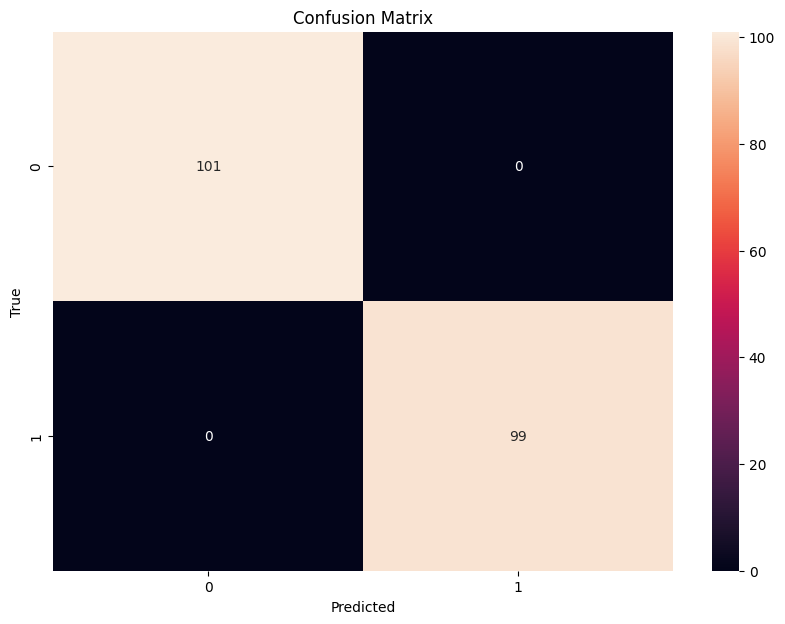

In [3]:
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = tokenized["test"]["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用seaborn绘制混淆矩阵的热力图
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 加载测试数据
test_data = pd.read_parquet("./datasets/FinQuestions_v2/test.parquet")

# 预测
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = test_data["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 找出预测错误的案例
wrong_predictions = test_data[predictions != true_labels]

# 打印预测错误的案例
for index, row in wrong_predictions.iterrows():
    print(f"True Label: {row['label']}, Predicted Label: {predictions[index]}, Text: {row['text']}")

  0%|          | 0/2 [00:00<?, ?it/s]

Confusion Matrix:
[[101   0]
 [  0  99]]


In [5]:
text = "解释一下量化宽松什么意思"

# classifier = pipeline("sentiment-analysis", model=output_dir+"/checkpoint-50")
# classifier(text)